In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from utils import *
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

%reload_ext autoreload
%autoreload 2
%matplotlib inline

def wjaccard_on_dist(a, b):
    mn = np.sum(np.minimum(a[:,0], b[:,0]))
    mx = np.sum(np.maximum(a[:,0], b[:,0]))
    return mn/mx


def attach_new_metric(df):
    new_metric = compute_metric(df, wjaccard_on_dist)
    df['wjaccard_dist_ksim'] = new_metric[:,0]
    df['wjaccard_dist_paa'] = new_metric[:,1]
    return df

prefix='../../results/'

df_ItalyPowerDemand = attach_new_metric(read_results_file(prefix + 'ksim_ItalyPowerDemand_0.1_results.txt'))
df_ItalyPowerDemand_out = attach_new_metric(read_results_file(prefix + 'ksim_outside_ItalyPowerDemand_0.1_results.txt'))
df_ItalyPowerDemand_all = pd.concat([df_ItalyPowerDemand, df_ItalyPowerDemand], ignore_index=True)

df_ECG200 = attach_new_metric(read_results_file(prefix + 'ksim_ECG200_0.1_results.txt'))
df_ECG200_out = attach_new_metric(read_results_file(prefix + 'ksim_outside_ECG200_0.1_results.txt'))
df_ECG200_all = pd.concat([df_ECG200, df_ECG200_out], ignore_index=True)

df_synthetic_control = attach_new_metric(read_results_file(prefix + 'ksim_synthetic_control_0.1_results.txt'))
df_synthetic_control_out = attach_new_metric(read_results_file(prefix + 'ksim_outside_synthetic_control_0.1_results.txt'))
df_synthetic_control_all = pd.concat([df_synthetic_control, df_synthetic_control_out], ignore_index=True)

df_Gun_Point = attach_new_metric(read_results_file(prefix + 'ksim_Gun_Point_0.1_results.txt'))
df_Gun_Point_out = attach_new_metric(read_results_file(prefix + 'ksim_outside_Gun_Point_0.1_results.txt'))
df_Gun_Point_all = pd.concat([df_Gun_Point, df_Gun_Point_out], ignore_index=True)

df_MedicalImages = attach_new_metric(read_results_file(prefix + 'ksim_MedicalImages_0.1_results.txt'))
df_MedicalImages_out = attach_new_metric(read_results_file(prefix + 'ksim_outside_MedicalImages_0.1_results.txt'))
df_MedicalImages_all = pd.concat([df_MedicalImages, df_MedicalImages_out], ignore_index=True)

df_FaceAll = attach_new_metric(read_results_file(prefix + 'ksim_FaceAll_0.1_results.txt'))
df_FaceAll_out = attach_new_metric(read_results_file(prefix + 'ksim_outside_FaceAll_0.1_results.txt'))
df_FaceAll_all = pd.concat([df_FaceAll, df_FaceAll_out], ignore_index=True)


In [218]:
all_dataset_names = ['ItalyPowerDemand', 'ECG200', 'synthetic_control', 'Gun_Point', 'MedicalImages', 'Face (All)']
all_datasets = [df_ItalyPowerDemand_all, df_ECG200_all, df_synthetic_control_all, df_Gun_Point_all, df_MedicalImages_all, df_FaceAll_all]
all_sizes = np.array([30084, 456000, 531000, 1676250, 3686760, 14390350])

# Running time

In [289]:
def time_best_match(df, metric, k):
    dfk = df[df.k == k]
    examples = dfk[['ts_index', 'ts_start', 'ts_end']].drop_duplicates()
    metric_col = metric + '_ksim'
    counter = 0
    time_ksim, time_bf, time_paa = [], [], []
    for index, row in examples.iterrows():
        counter += 1
        selector = ((dfk['ts_index'] == row['ts_index']) 
                    & (dfk['ts_start'] == row['ts_start'])
                    & (dfk['ts_end'] == row['ts_end']))
        current = dfk[selector][[metric_col, 'time_ksim', 'time_bf', 'time_paa']]
        idxmax = current[metric_col].idxmax()
        time_ksim.append(current['time_ksim'][idxmax])
        time_bf.append(current['time_bf'][idxmax])
        time_paa.append(current['time_paa'][idxmax])
    
    return np.array(time_ksim), np.array(time_bf), np.array(time_paa)

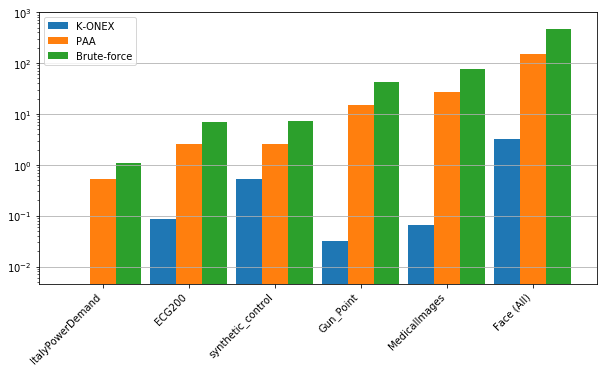

In [354]:
n = len(all_datasets)
time_ksim = np.empty((n, 2))
time_bf = np.empty((n, 2))
time_paa = np.empty((n, 2))

for i, d in enumerate(all_datasets):
    ksim, bf, paa = time_best_match(d, 'wjaccard_dist', 1)
    time_ksim[i, :] = (ksim.mean(), ksim.std())
    time_bf[i, :] = (bf.mean(), bf.std())
    time_paa[i, :] = (paa.mean(), paa.std())

f, ax = plt.subplots(1, figsize=(10,5))
ax.yaxis.grid('on')
ax.set_yscale('log')

barwidth = 0.3
x = np.arange(0, len(all_datasets))

error_config = {'capsize': 2, 'capthick': 1}

ax.bar(x, time_ksim[:, 0], barwidth, label='K-ONEX')
#        yerr=time_ksim[:, 1],
#        error_kw=error_config)
ax.bar(x + barwidth, time_paa[:, 0], barwidth, label='PAA')
#        yerr=time_ksim[:, 1],
#        error_kw=error_config)
ax.bar(x + 2*barwidth, time_bf[:, 0], barwidth, label='Brute-force')
#        yerr=time_ksim[:, 1],
#        error_kw=error_config)

ax.set_ylim(0, 1000)
ax.set_xticks(x + barwidth)
ax.set_xticklabels(all_dataset_names)
plt.setp(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
ax.legend()
plt.savefig('time_comparison.eps')
plt.show()

# Explored proportion

In [349]:
def min_explored_proportion(df, metric, k):
    dfk = df[df.k == k]
    examples = dfk[['ts_index', 'ts_start', 'ts_end']].drop_duplicates()

    h = []
    extra = []
    metric_col = metric + '_ksim'    
    for index, row in examples.iterrows():
        selector = ((dfk['ts_index'] == row['ts_index']) 
                    & (dfk['ts_start'] == row['ts_start'])
                    & (dfk['ts_end'] == row['ts_end']))
        current = dfk[selector][[metric_col, 'h', 'h_extra']].drop_duplicates()
        
        idxmax = current[metric_col].idxmax()
        h.append(current.h[idxmax])
        extra.append(current.h_extra[idxmax] - current.h[idxmax])

    return np.array(h), np.array(extra)


def explored_all_datasets(k):
    explored = np.empty((len(all_datasets), 3))
    for i, d in enumerate(all_datasets):
        h, extra = min_explored_proportion(d, 'wjaccard_dist', k)
        explored[i, :2] = (h.mean(), h.std())

    explored[:, :2] = explored[:, :2] / all_sizes.reshape((-1, 1)) * 100
    explored[:, 2] = 100 - explored[:, 0]
    return pd.DataFrame(explored, columns=['h_mean', 'h_std', 'rest'])


def plot_proportion(ax, df, yscale):
    
    ax.set_yscale(yscale)
    bar_width = 1
    
    # positions of the left bar-boundaries
    bar_l = [i for i in range(len(df.h_mean))] 
    # positions of the x-axis ticks (center of the bars as bar labels)
    tick_pos = [i+(bar_width/2) for i in bar_l] 

    h_mean = df.h_mean.values
    h_std = df.h_std.values
#     extra = df.extra.values
    rest = df.rest.values
    
    # Plot h
    ax.bar(bar_l, h_mean, yerr=h_std, error_kw=dict(ecolor='red', lw=1, capsize=3, capthick=1),
           label='$k_e$', alpha=0.8, color='green', width=bar_width, edgecolor='white', linewidth=0.5)

#     # Plot extra
#     ax.bar(bar_l, extra, bottom=h, label='last group',
#            alpha=0.5, color='red', width=bar_width, edgecolor='white', linewidth=0.5)


    ax.bar(bar_l, rest, bottom=h_mean, label='unexplored',
           alpha=0.5, color='orange', width=bar_width, edgecolor='white', linewidth=0.5)

    ax.set_xticks(tick_pos)
    ax.set_xticklabels(all_dataset_names)
    ax.set_ylabel("Percent of total dataset size")
    ax.set_xlabel("")

    ax.set_xlim([min(tick_pos)-bar_width, max(tick_pos)+bar_width])
    ax.set_ylim(0, 110)
    
    # rotate axis labels
    plt.setp(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
    
    

## K = 1

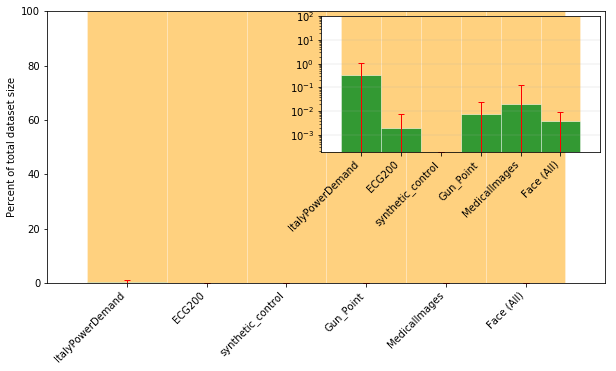

In [350]:
df = explored_all_datasets(1)

# Create a figure with a single subplot
f, ax = plt.subplots(1, figsize=(10,5))

plot_proportion(ax, df, 'linear')
# ax.legend(True)
axins = zoomed_inset_axes(ax, 0.5, loc=1)
axins.yaxis.grid('on', linewidth=0.2, zorder=1)

plot_proportion(axins, df, "log")
axins.set_ylabel("")
plt.savefig('dataset_proportion_k1.eps')
# shot plot
plt.show()

## K = 9

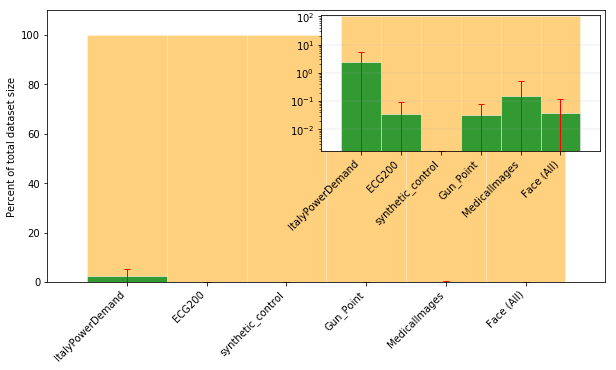

In [296]:
df = explored_all_datasets(9)

# Create a figure with a single subplot
f, ax = plt.subplots(1, figsize=(10,5))

plot_proportion(ax, df, 'linear')
axins = zoomed_inset_axes(ax, 0.5, loc=1)
axins.yaxis.grid('on', linewidth=0.2, zorder=1)
plot_proportion(axins, df, "log")
axins.set_ylabel("")

plt.savefig('dataset_proportion_k9.eps')
# shot plot
plt.show()

## K = 15

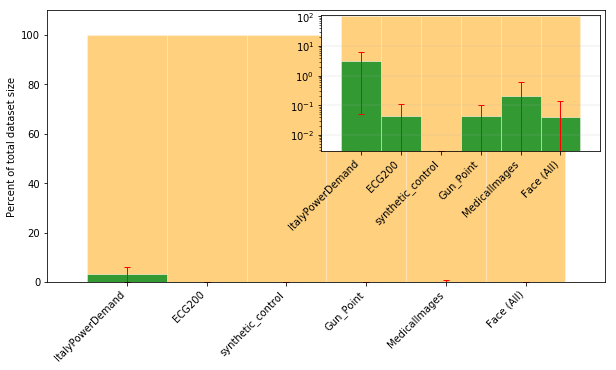

In [297]:
df = explored_all_datasets(15)

# Create a figure with a single subplot
f, ax = plt.subplots(1, figsize=(10,5))

plot_proportion(ax, df, 'linear')
axins = zoomed_inset_axes(ax, 0.5, loc=1)
axins.yaxis.grid('on', linewidth=0.2, zorder=1)
plot_proportion(axins, df, "log")
axins.set_ylabel("")

plt.savefig('dataset_proportion_k15.eps')
# shot plot
plt.show()